In [18]:
!pip install scikit-optimize
# !pip install xgboost
# !pip install lazypredict
# !pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 100.3/100.3 kB 1.9 MB/s eta 0:00:00


In [19]:
import pandas as pd 
import numpy as np
import sklearn
import pickle
import matplotlib.pyplot as plt
import lazypredict
import xgboost as xgb

from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV

from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb


In [20]:
def make_submission(preds):
    assert len(preds) == 5000
    
    # Read labels
    with open('test_labels_sorted.npy', 'rb') as f:
        test_labels = np.load(f)
    len(test_labels)
    
    submission = pd.DataFrame(columns=['id', 'class'])
    for label, pred in zip(test_labels, preds):
        submission = submission.append({'id': label, 'class': pred}, ignore_index=True)
    return submission

In [21]:
def plot_confusion_matrix(y_val_from_train, y_pred_from_train):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(y_val_from_train, y_pred_from_train),
    #     display_labels=["class_1", "class_2", "class_3", "class_4"],
    )

    cmp.plot(ax=ax)
    plt.show();

In [22]:
def sub_1(y_train):
    y_copy = y_train
    for i in range(len(y_copy)):
        y_copy[i] -= 1
    return y_copy

def add_1(xgb_preds):
    xgb_preds_copy = xgb_preds
    for i in range(len(xgb_preds_copy)):
        xgb_preds_copy[i] += 1
    return xgb_preds_copy

# Load X_train, y_train, X_test

In [23]:
# Load X_train
with open('3_features_per_axis/X_train_9.npy', 'rb') as f:
    X_train = np.load(f)
print(X_train.shape)
X_train

(9000, 9)


array([[ 1.59010940e-01,  5.44393051e-01,  2.96363794e-01, ...,
         8.13342643e+00,  4.42429811e-01,  1.95744138e-01],
       [ 1.74547752e-01,  6.17015065e-01,  3.80707590e-01, ...,
         8.72946826e+00,  3.86236664e-01,  1.49178761e-01],
       [-1.61696002e+00,  8.51122136e-01,  7.24408891e-01, ...,
         8.03634944e+00,  4.18813963e-01,  1.75405135e-01],
       ...,
       [-4.06112460e-01,  6.55641942e-01,  4.29866356e-01, ...,
         8.77203979e+00,  5.35075014e-01,  2.86305270e-01],
       [ 8.15228667e-03,  6.80594980e-01,  4.63209527e-01, ...,
         8.48209796e+00,  8.69155016e-01,  7.55430442e-01],
       [-5.17633651e-01,  5.38173469e-01,  2.89630682e-01, ...,
         7.45196084e+00,  3.49370740e-01,  1.22059914e-01]])

In [24]:
# Load y_train
with open('3_features_per_axis/y_train_9.npy', 'rb') as f:
    y_train = np.load(f)
print(y_train.shape)
y_train

(9000,)


array([ 7, 13,  6, ...,  3,  3, 18], dtype=int64)

In [25]:
# Load X_train
with open('3_features_per_axis/X_test_9.npy', 'rb') as f:
    X_test = np.load(f)
print(X_test.shape)
X_test

(5000, 9)


array([[-3.05412347e-01,  7.42857043e-01,  5.51836586e-01, ...,
         8.57556766e+00,  9.65011797e-01,  9.31247768e-01],
       [-3.54157081e-01,  7.94335631e-01,  6.30969095e-01, ...,
         7.68358773e+00,  4.39248036e-01,  1.92938837e-01],
       [-8.47212227e-01,  3.84535013e-01,  1.47867176e-01, ...,
         8.73888807e+00,  3.90374426e-01,  1.52392192e-01],
       ...,
       [ 4.29758667e-03,  3.23994204e-01,  1.04972244e-01, ...,
         7.25703291e+00,  4.84647030e-01,  2.34882744e-01],
       [-1.05151830e+00,  5.01833910e-01,  2.51837273e-01, ...,
         8.55153351e+00,  4.80319851e-01,  2.30707159e-01],
       [-5.40031205e-01,  4.61364725e-01,  2.12857410e-01, ...,
         8.50877877e+00,  6.51297512e-01,  4.24188449e-01]])

# Train Validation Split

In [26]:
# Create validation data
# Train/test sets
X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

# Lazy Classifier

In [63]:
# Lazy Classifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train)
models

100%|██████████| 29/29 [00:11<00:00,  2.55it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.90,0.90,None,0.90,0.46
LGBMClassifier,0.90,0.90,None,0.90,0.60
RandomForestClassifier,0.89,0.89,None,0.89,1.30
BaggingClassifier,0.86,0.86,None,0.86,0.35
SVC,0.86,0.86,None,0.86,0.60
LabelSpreading,0.86,0.86,None,0.86,1.41
LabelPropagation,0.85,0.86,None,0.85,0.82
LogisticRegression,0.84,0.84,None,0.84,0.35
QuadraticDiscriminantAnalysis,0.84,0.84,None,0.84,0.01


## ETC Classifier - Bayes Search CV

In [ ]:
param_grid = {
    "max_depth": [13, 15, 20, 25],
    "learning_rate": [0.03,  0.05, 0.07],
    'num_leaves': [50, 75, 100, 150],
    "colsample_bytree": [0.5, 0.7],
    "subsample": [0.7, 0.8, 0.9],
    "reg_lambda": [0],
    'reg_alpha' : [0.3, 0.4, 0.5, 0.7],
    
}

In [ ]:
# Fit on train-validation data
etc = ExtraTreesClassifier(n_estimators=1000, random_state=0)
_ = etc.fit(X_train_from_train, y_train_from_train)
y_pred_from_train = etc.predict(X_val_from_train)

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(y_val_from_train, y_pred_from_train)

In [ ]:
# Accuracy Score
accuracy_score(y_val_from_train, y_pred_from_train)

In [ ]:
# Make test preds
preds = etc.predict(X_test)
print(preds.shape, preds)
print(min(preds), max(preds))

In [ ]:
submission = make_submission(preds)
submission

In [ ]:
submission.to_csv('submission_15f_etc_50000.csv', index=False)

## LGBM Classifier - Bayes Search CV

In [46]:
param_grid = {
    "max_depth": [13, 15, 20, 25],
    "learning_rate": [0.03,  0.05, 0.07],
    "num_leaves": [50, 75, 100, 150],
    "colsample_bytree": [0.5, 0.7],
    "subsample": [0.7, 0.8, 0.9],
    "reg_lambda": [0],
    'reg_alpha' : [0.3, 0.4, 0.5, 0.7],
    
}

In [47]:
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', objective = 'multiclass', n_jobs = -1, max_depth=-1, max_bin=600, )

In [48]:
cv = RepeatedStratifiedKFold(n_splits=7, random_state=1)
grid = BayesSearchCV(mdl, param_grid, verbose=1, cv=cv, n_jobs=-1)

In [49]:
%%time
grid.fit(X_train_from_train, y_train_from_train)

Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for each of 1 candidates, totalling 70 fits
Fitting 70 folds for eac

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=7, random_state=1),
              estimator=LGBMClassifier(max_bin=400, objective='multiclass'),
              n_jobs=-1,
              search_spaces={'colsample_bytree': [0.5, 0.7],
                             'learning_rate': [0.03, 0.05, 0.07],
                             'max_depth': [13, 15, 20, 25],
                             'num_leaves': [50, 75, 100, 150],
                             'reg_alpha': [0.3, 0.4, 0.5, 0.7],
                             'reg_lambda': [0], 'subsample': [0.7, 0.8, 0.9]},
              verbose=1)

In [50]:
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

OrderedDict([('colsample_bytree', 0.6963542039594772), ('learning_rate', 0.07), ('max_depth', 13), ('num_leaves', 50), ('reg_alpha', 0.3), ('reg_lambda', 0), ('subsample', 0.7)])
0.8866012870064628


In [51]:
print(grid.best_estimator_)

LGBMClassifier(colsample_bytree=0.6963542039594772, learning_rate=0.07,
               max_bin=400, max_depth=13, num_leaves=50, objective='multiclass',
               reg_alpha=0.3, reg_lambda=0, subsample=0.7)


In [52]:
y_pred_from_train = grid.predict(X_val_from_train)
# y_pred_from_train = add_1(y_pred_from_train)
print(min(y_val_from_train), min(y_pred_from_train)) 

1 1


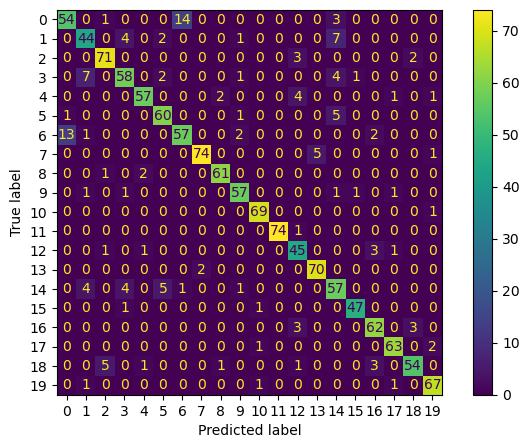

In [53]:
plot_confusion_matrix(y_val_from_train, y_pred_from_train)

In [54]:
accuracy_score(y_val_from_train, y_pred_from_train)

0.8896296296296297

### Final attempt at LGBM

In [56]:
# TODO try lgbm clsf using the given params, using eval_set and 10k estimators. 
# Then create submission. If it's worse than previous attempts, just dump it altogether.

In [57]:
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', objective = 'multiclass', n_jobs = -1, max_depth=-1, max_bin=600, n_estimators=10000)

In [58]:
%%time
eval_set=[(X_val_from_train, y_val_from_train)]
mdl.fit(X_train_from_train, y_train_from_train, eval_set=eval_set)

[1]	valid_0's multi_logloss: 1.7591
[2]	valid_0's multi_logloss: 1.46191
[3]	valid_0's multi_logloss: 1.25607
[4]	valid_0's multi_logloss: 1.10241
[5]	valid_0's multi_logloss: 0.982715
[6]	valid_0's multi_logloss: 0.88296
[7]	valid_0's multi_logloss: 0.804822
[8]	valid_0's multi_logloss: 0.73938
[9]	valid_0's multi_logloss: 0.684083
[10]	valid_0's multi_logloss: 0.639562
[11]	valid_0's multi_logloss: 0.600244
[12]	valid_0's multi_logloss: 0.565953
[13]	valid_0's multi_logloss: 0.536159
[14]	valid_0's multi_logloss: 0.511572
[15]	valid_0's multi_logloss: 0.491775
[16]	valid_0's multi_logloss: 0.472975
[17]	valid_0's multi_logloss: 0.457553
[18]	valid_0's multi_logloss: 0.445241
[19]	valid_0's multi_logloss: 0.433432
[20]	valid_0's multi_logloss: 0.423266
[21]	valid_0's multi_logloss: 0.414212
[22]	valid_0's multi_logloss: 0.405596
[23]	valid_0's multi_logloss: 0.398406
[24]	valid_0's multi_logloss: 0.392255
[25]	valid_0's multi_logloss: 0.386786
[26]	valid_0's multi_logloss: 0.381655
[2

LGBMClassifier(max_bin=600, n_estimators=10000, objective='multiclass')

In [59]:
preds = mdl.predict(X_test)

In [60]:
preds

array([ 3,  4,  5, ..., 10,  5,  7], dtype=int64)

In [61]:
sub = make_submission(preds)
sub

,id,class
0,10001,3
1,10002,4
2,10004,5
3,10008,20
4,10009,13
...,...,...
4995,23986,9
4996,23991,12
4997,23992,10
4998,23998,5


In [62]:
sub.to_csv('submission_lgbm_baseline_3f_withoutns.csv', index=False)

## XGB - Grid Search CV

In [10]:
param_grid = {
    "max_depth": [3, 4, 5, 7, 9, 11, 13],
    "learning_rate": [0.2, 0.15, 0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 0.5, 0.75, 1],
    "reg_lambda": [0, 1, 3, 5, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.3, 0.5, 0.8],
    "colsample_bytree": [0.3, 0.5, 0.7],
}

In [11]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
xgb_cl = xgb.XGBClassifier(objective="multi:softmax", gpu_id=0)
# xgb_cl.fit(X_train_from_train, sub_1(y_train_from_train))

In [12]:
# scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'weighted')
scoring = {'accuracy': make_scorer(accuracy_score),
           'f1_micro': make_scorer(recall_score, average = 'micro'),
           'f1_macro': make_scorer(f1_score, average = 'macro'),
           'f1_weighted': make_scorer(f1_score, average = 'weighted')}
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, scoring=scoring, cv=cv)

Wall time: 0 ns


In [13]:
%%time
grid_cv.fit(X_train_from_train, sub_1(y_train_from_train))

[08:38:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None, gpu_id=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
     

In [15]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [18]:
y_pred_from_train = grid_cv.predict(X_val_from_train)
y_pred_from_train = add_1(y_pred_from_train)

In [19]:
print(min(y_val_from_train), min(y_pred_from_train)) 

1 1


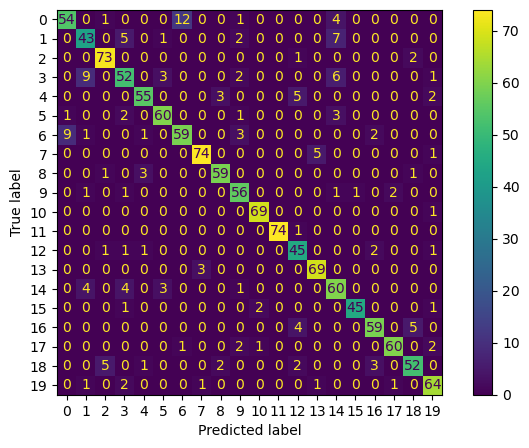

In [20]:
plot_confusion_matrix(y_val_from_train, y_pred_from_train)

In [21]:
print(min(y_val_from_train), min(y_pred_from_train)) 

1 1


In [22]:
accuracy_score(y_val_from_train, y_pred_from_train)

0.8755555555555555

In [23]:
preds = grid_cv.predict(X_test)
preds = add_1(preds)
print(min(preds))

1


In [24]:
sub = make_submission(preds)
sub

,id,class
0,10001,3
1,10002,4
2,10004,5
3,10008,20
4,10009,5
...,...,...
4995,23986,9
4996,23991,12
4997,23992,18
4998,23998,5


In [25]:
sub.to_csv('submission_gridcv_xgb_baseline_3f_withoutns.csv', index=False)

## XGB - Random Search CV

In [56]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
xgb_cl = xgb.XGBClassifier(objective="multi:softmax", gpu_id=0)

In [57]:
param_grid = {
    "max_depth": [3, 4, 5, 7, 9, 11, 13, 15],
    "learning_rate": [0.3, 0.2, 0.15, 0.1, 0.01, 0.05],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.25, 0.5, 0.75, 1],
    "reg_lambda": [0, 1, 3, 5, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.3, 0.5, 0.8],
    "colsample_bytree": [0.3, -.4, 0.5, 0.7],
}

In [58]:
# scoring = {'accuracy': sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score, greater_is_better=True),
#            'f1_micro': sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'micro', greater_is_better=True),
#            'f1_macro': sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'macro', greater_is_better=True),
#            'f1_weighted': sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'weighted', greater_is_better=True)}
scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'macro')
rs_cv = RandomizedSearchCV(xgb_cl, param_grid, n_jobs=-1, scoring=scorer, cv=cv)

In [59]:
print(min(y_train_from_train))

1


In [60]:
%%time
rs_cv.fit(X_train_from_train, sub_1(y_train_from_train))

[10:47:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Wall time: 1min 33s


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=0,
                                           grow_policy=None,
                                           impo...
                                           objective='multi:softmax',
                                           predictor=None, ...),
                   n_jobs=-1,
                

In [61]:
rs_cv.best_params_

{'subsample': 0.8,
 'scale_pos_weight': 1,
 'reg_lambda': 3,
 'min_child_weight': 5,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 0.5}

In [62]:
rs_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softmax', predictor='auto', ...)

In [64]:
y_pred_from_train = rs_cv.predict(X_val_from_train)
y_pred_from_train = add_1(y_pred_from_train)
print(min(y_val_from_train), min(y_pred_from_train)) 

1 1


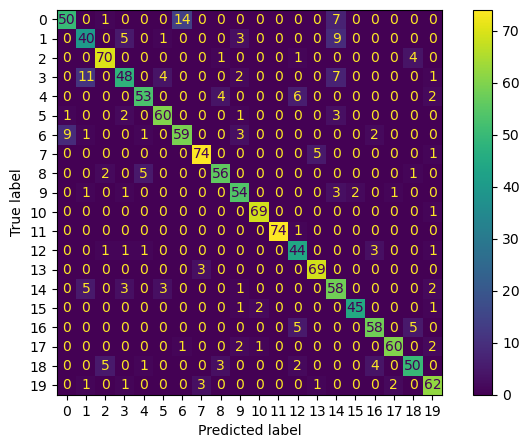

In [65]:
plot_confusion_matrix(y_val_from_train, y_pred_from_train)

In [66]:
accuracy_score(y_val_from_train, y_pred_from_train)

0.8540740740740741